# S11 T01: Practicant amb training i test sets

## Preprocessing

In [2]:
# Actualitzem sklearn a la darrera versió (Colab porta la 0.22 per defecte, enlloc de la darrera 0.24.2)
!pip install -U scikit-learn &> /dev/null 

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from scipy import stats
from itertools import zip_longest

# Configuration
%matplotlib inline
set_config(display='diagram')

In [4]:
# Importar DataSet des de Kaggle

# Nota: l'afegit '&> /dev/null' evita que es mostrin en el notebook el resultat
# d'executar commanes de terminal com pip, wget, etc. I així el notebook queda més net. 

datasetName = 'giovamata/airlinedelaycauses'
zipName = 'airlinedelaycauses.zip'

#Esborrem contingut de la carpeta '/content' de GoogleColab
!rm /content/*.* &> /dev/null 

!pip install kaggle &> /dev/null

!wget -O kaggle.json https://www.dropbox.com/s/xm28qj0cdfopm6c/kaggle.json?dl=0 &> /dev/null
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json &> /dev/null

!kaggle datasets download $datasetName &> /dev/null

!unzip $zipName

Archive:  airlinedelaycauses.zip
  inflating: DelayedFlights.csv      
  inflating: st99_d00.dbf            
  inflating: st99_d00.shp            
  inflating: st99_d00.shx            


In [5]:
df = pd.read_csv('/content/DelayedFlights.csv', index_col=0)
df.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [6]:
# Eliminem FlightNum perquè no aporta cap informació (és arbitrari, hi poden haver diversos vols amb mateix número)
df.drop(columns=['FlightNum'], inplace=True)

# Eliminem Year perquè tots els registres que tenim són de l'any 2008 per tant no aporta cap informació
df.drop(columns=['Year'], inplace=True)

In [7]:
# Renombrem la columna DayofMonth a DayOfMonth
df.rename(columns = {'DayofMonth': 'DayOfMonth'}, inplace = True)

# Canviem tipus de Month, DayOfMonth, DayOfWeek i CancellationCode a categòric
df[['Month','DayOfMonth','DayOfWeek', 'CancellationCode']] = df[['Month','DayOfMonth','DayOfWeek', 'CancellationCode']].astype('category')

# Canviem tipus de Cancelled i Diverted a boolean (binari)
df[['Cancelled','Diverted']] = df[['Cancelled','Diverted']].astype('bool')

In [8]:
df.head()

,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003.0,1955,2211.0,2225,WN,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,False,N,False,NaN,NaN,NaN,NaN,NaN
1,1,3,4,754.0,735,1002.0,1000,WN,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,False,N,False,NaN,NaN,NaN,NaN,NaN
2,1,3,4,628.0,620,804.0,750,WN,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,False,N,False,NaN,NaN,NaN,NaN,NaN
4,1,3,4,1829.0,1755,1959.0,1925,WN,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,False,N,False,2.0,0.0,0.0,0.0,32.0
5,1,3,4,1940.0,1915,2121.0,2110,WN,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,False,N,False,NaN,NaN,NaN,NaN,NaN


## Exercici 1
**Parteix el conjunt de dadesDelayedFlights.csv en train i test. Estudia els dos conjunts per separat, a nivell descriptiu.**

In [9]:
# Separem el dataset en train set (70%) i test set (30%)

df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df.drop(columns=['ArrDelay']), df['ArrDelay'], test_size=0.3, random_state=123, shuffle=True)

La funció describe() de Pandas no dona informació gaire útil per a les variables categòriques. M'he creat la meva pròpia funció **summary_flights()**
que per a les variables categòriques (Origin, Dest, UniqueCarrier) indica nombre de valors únics i els 5 valors més y menys freqüents. També he creat una funció **summary_journeys()** que mostra informació sobre els trajectes ( = Journeys = permutacions de Origin i Dest) més y menys freqüents.

In [10]:
# Separem les columnes segons els tipus d'anàlisi descriptiu a fer (numèric vs categòric)

# Columnes Numèriques
num_columns = list(df_X_train.select_dtypes('number').columns)
print(f"Numerical features are: {num_columns}")

# Columnes Categòriques (= les que no són numèriques)
# Nota: les variables Month, DayOfMonth i DayOfWeek les analitzem com "categòriques" 
cat_columns = list(set(df_X_train.columns) - set(num_columns))
print(f"Categorical features are: {cat_columns}")


Numerical features are: ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
Categorical features are: ['UniqueCarrier', 'Diverted', 'Dest', 'Cancelled', 'Month', 'DayOfMonth', 'DayOfWeek', 'TailNum', 'Origin', 'CancellationCode']


In [11]:
# Funció per fer anàlisi descriptiu dels vols
def summary_flights(df, num_columns, cat_columns, freq_length=5):
  '''
  Prints statistical summary of numeric and categorical attributes of a Dataframe
    df: DataFrame
    num_columns: list of names of numeric columns
    cat_columns: list of names of categorical columns
    freq_length: number of values to show for "most" and "less" frequent values
  '''

  if len(num_columns) != 0:
    print(f'Statistical summary of numerical columns:')
    foo = df[num_columns].describe().T
    foo['missing'] = df[num_columns].isna().sum()
    display(foo)

  if len(cat_columns) !=0:
    print(f'\n-------------------------------------------')

    print(f'\nStatistical summary of categorical columns:')

    #unique_values = [f'{var}:{df[var].nunique()}' for var in cat_columns]
    print(f'\nNumber of unique values and number of missing values:')
    #print(*unique_values, sep=', ')
    foo = pd.DataFrame(columns=cat_columns)
    foo.loc['unique'] = df[cat_columns].nunique()
    foo.loc['missing'] = df[cat_columns].isna().sum()
    display(foo)

    first_df = pd.DataFrame(columns=range(1,freq_length+1))
    last_df = pd.DataFrame(columns=range(1,freq_length+1))
    
    for var in cat_columns:

      x = df[var].value_counts(normalize=False, sort=True, ascending=False)
      
      # Creem una llista de tuples (value, count) per als valors més freqüents
      x_first = list(zip(x[0:freq_length].index, x[0:freq_length]))

      # Si hi ha menys de 5 valors, completem els elements restants amb string '-'
      x_first.extend(['-']*(freq_length-len(x_first)))

      # Afegim fila al DataFrame
      first_df.loc[var] = x_first

      # Idem que anterior pèro per 5 valors menys freqüents
      x_last = list(zip(x[-freq_length:].index, x[-freq_length:]))
      x_last.reverse()
      x_last.extend(['-']*(freq_length-len(x_last)))
      last_df.loc[var] = x_last 

    print(f'\n\n{freq_length} most frequent values (value, count):')
    display(first_df)

    print(f'\n\n{freq_length} less frequent values (value, count):')
    display(last_df)

    print(f'\n-------------------------------------------')

  


# Funció per fer anàlisi descriptiu dels trajectes
def summary_journeys(df, origin_column='Origin', destination_column='Dest', freq_length=5):
  '''
  Prints statistical summary of journeys
    df: DataFrame
    origin_column: name of the column that contains Origin airport of the journey
    destination_column: name of the column that contains Destination airport of the journey
    freq_length: number of values to show for "most" and "less" frequent values
  '''

  journeys = df[[origin_column, destination_column]].value_counts(sort=True, ascending=False)

  print(f'\nStatistical summary of Journeys (= permutations of Origin and Destination values):')
  
  print(f'\nNumber of unique values: {journeys.size}')

  print(f'\n\n{freq_length} most frequent values:')
  display(journeys[0:freq_length].to_frame(name='Total').reset_index())
  
  print(f'\n\n{freq_length} less frequent values:')
  display(journeys[-freq_length:].to_frame(name='Total').reset_index())


In [12]:
# Anàlisi descriptiu del TRAINING SET
print(f'---------------- Training Set ----------------\n')
summary_flights(df_X_train, num_columns, cat_columns, freq_length=5)
summary_journeys(df_X_train, origin_column='Origin', destination_column='Dest', freq_length=5)

---------------- Training Set ----------------

Statistical summary of numerical columns:


,count,mean,std,min,25%,50%,75%,max,missing
DepTime,1355730.0,1518.480073,450.461319,1.0,1203.0,1545.0,1900.0,2400.0,0
CRSDepTime,1355730.0,1467.572925,424.671723,0.0,1135.0,1510.0,1815.0,2359.0,0
ArrTime,1350701.0,1610.193240,548.190784,1.0,1316.0,1715.0,2030.0,2400.0,5029
CRSArrTime,1355730.0,1634.076882,464.840569,0.0,1325.0,1705.0,2014.0,2400.0,0
ActualElapsedTime,1349819.0,133.304208,72.019605,15.0,80.0,116.0,165.0,790.0,5911
CRSElapsedTime,1355588.0,134.303541,71.315420,-25.0,82.0,116.0,165.0,660.0,142
AirTime,1349819.0,108.268287,68.611149,0.0,58.0,90.0,137.0,733.0,5911
DepDelay,1355730.0,43.166521,53.341718,6.0,12.0,24.0,53.0,2467.0,0
Distance,1355730.0,765.721573,574.376965,11.0,338.0,606.0,998.0,4962.0,0
TaxiIn,1350701.0,6.815835,5.291006,0.0,4.0,6.0,8.0,225.0,5029



-------------------------------------------

Statistical summary of categorical columns:

Number of unique values and number of missing values:


,UniqueCarrier,Diverted,Dest,Cancelled,Month,DayOfMonth,DayOfWeek,TailNum,Origin,CancellationCode
unique,20,2,302,2,12,31,7,5360,301,4
missing,0,0,0,0,0,0,0,3,0,0




5 most frequent values (value, count):


,1,2,3,4,5
UniqueCarrier,"(WN, 264689)","(AA, 134524)","(MQ, 99257)","(UA, 99036)","(OO, 92614)"
Diverted,"(False, 1350279)","(True, 5451)",-,-,-
Dest,"(ORD, 76056)","(ATL, 75034)","(DFW, 49607)","(DEN, 44163)","(LAX, 41977)"
Cancelled,"(False, 1355270)","(True, 460)",-,-,-
Month,"(12, 142683)","(6, 140893)","(3, 140222)","(2, 132519)","(1, 128760)"
DayOfMonth,"(22, 50139)","(21, 49075)","(1, 47281)","(7, 47208)","(15, 45892)"
DayOfWeek,"(5, 226291)","(1, 203584)","(4, 202484)","(7, 200212)","(3, 183852)"
TailNum,"(N313SW, 687)","(N676SW, 673)","(N658SW, 663)","(N308SA, 659)","(N325SW, 658)"
Origin,"(ATL, 91862)","(ORD, 88283)","(DFW, 66851)","(DEN, 51973)","(LAX, 41205)"
CancellationCode,"(N, 1355270)","(B, 212)","(A, 188)","(C, 60)",-




5 less frequent values (value, count):


,1,2,3,4,5
UniqueCarrier,"(AQ, 520)","(HA, 5174)","(F9, 19739)","(AS, 27584)","(9E, 36067)"
Diverted,"(True, 5451)","(False, 1350279)",-,-,-
Dest,"(CYS, 1)","(PIR, 2)","(BJI, 6)","(INL, 7)","(ITH, 9)"
Cancelled,"(True, 460)","(False, 1355270)",-,-,-
Month,"(9, 66779)","(10, 72346)","(11, 73827)","(5, 107113)","(4, 108779)"
DayOfMonth,"(31, 27031)","(29, 39777)","(30, 39782)","(25, 41453)","(5, 42054)"
DayOfWeek,"(6, 156607)","(2, 182700)","(3, 183852)","(7, 200212)","(4, 202484)"
TailNum,"(N826MH, 1)","(N171UA, 1)","(N2AEMQ, 1)","(N27015, 1)","(N171DN, 1)"
Origin,"(PUB, 1)","(BJI, 2)","(PIR, 2)","(BLI, 3)","(WYS, 7)"
CancellationCode,"(C, 60)","(A, 188)","(B, 212)","(N, 1355270)",-



-------------------------------------------

Statistical summary of Journeys (= permutations of Origin and Destination values):

Number of unique values: 5130


5 most frequent values:


,Origin,Dest,Total
0,LAX,SFO,3243
1,ORD,LGA,3098
2,SFO,LAX,2848
3,ATL,LGA,2815
4,LAS,LAX,2450




5 less frequent values:


,Origin,Dest,Total
0,ICT,STL,1
1,ICT,SLC,1
2,SLC,SGF,1
3,BOS,ACK,1
4,SFO,GJT,1


In [13]:
# Anàlisi descriptiu del TEST SET

print(f'---------------- Test Set ----------------\n')
summary_flights(df_X_test, num_columns, cat_columns, freq_length=5)
summary_journeys(df_X_test, origin_column='Origin', destination_column='Dest', freq_length=5)

---------------- Test Set ----------------

Statistical summary of numerical columns:


,count,mean,std,min,25%,50%,75%,max,missing
DepTime,581028.0,1518.660219,450.541462,1.0,1203.0,1545.0,1901.0,2400.0,0
CRSDepTime,581028.0,1467.238655,424.988836,1.0,1135.0,1510.0,1815.0,2359.0,0
ArrTime,578947.0,1610.017884,548.149102,1.0,1316.0,1715.0,2031.0,2400.0,2081
CRSArrTime,581028.0,1634.569411,464.154240,0.0,1325.0,1706.0,2015.0,2400.0,0
ActualElapsedTime,578552.0,133.309725,72.154449,14.0,80.0,116.0,165.0,1114.0,2476
CRSElapsedTime,580972.0,134.300884,71.402174,-10.0,82.0,116.0,165.0,660.0,56
AirTime,578552.0,108.297819,68.716011,0.0,58.0,90.0,137.0,1091.0,2476
DepDelay,581028.0,43.228707,53.544086,6.0,12.0,24.0,53.0,2457.0,0
Distance,581028.0,765.603527,574.719673,30.0,338.0,606.0,998.0,4962.0,0
TaxiIn,578947.0,6.806304,5.232749,0.0,4.0,6.0,8.0,240.0,2081



-------------------------------------------

Statistical summary of categorical columns:

Number of unique values and number of missing values:


,UniqueCarrier,Diverted,Dest,Cancelled,Month,DayOfMonth,DayOfWeek,TailNum,Origin,CancellationCode
unique,20,2,303,2,12,31,7,5339,303,4
missing,0,0,0,0,0,0,0,2,0,0




5 most frequent values (value, count):


,1,2,3,4,5
UniqueCarrier,"(WN, 112913)","(AA, 57341)","(MQ, 42663)","(UA, 42390)","(OO, 39819)"
Diverted,"(False, 578725)","(True, 2303)",-,-,-
Dest,"(ORD, 32928)","(ATL, 31864)","(DFW, 21050)","(DEN, 18840)","(LAX, 17992)"
Cancelled,"(False, 580855)","(True, 173)",-,-,-
Month,"(12, 60702)","(3, 60620)","(6, 60021)","(2, 57015)","(7, 55132)"
DayOfMonth,"(22, 21510)","(21, 21093)","(1, 20534)","(7, 20270)","(15, 19695)"
DayOfWeek,"(5, 96968)","(1, 87349)","(4, 86967)","(7, 85899)","(3, 78953)"
TailNum,"(N325SW, 307)","(N350SW, 293)","(N658SW, 282)","(N656SW, 282)","(N368SW, 281)"
Origin,"(ATL, 39751)","(ORD, 37696)","(DFW, 28563)","(DEN, 22350)","(LAX, 17567)"
CancellationCode,"(N, 580855)","(B, 95)","(A, 58)","(C, 20)",-




5 less frequent values (value, count):


,1,2,3,4,5
UniqueCarrier,"(AQ, 230)","(HA, 2316)","(F9, 8530)","(AS, 11709)","(OH, 15659)"
Diverted,"(True, 2303)","(False, 578725)",-,-,-
Dest,"(PIR, 1)","(OGD, 1)","(TUP, 1)","(BLI, 1)","(INL, 2)"
Cancelled,"(True, 173)","(False, 580855)",-,-,-
Month,"(9, 28760)","(10, 31179)","(11, 31736)","(5, 45959)","(4, 46485)"
DayOfMonth,"(31, 11709)","(30, 16939)","(29, 17116)","(25, 17603)","(3, 17866)"
DayOfWeek,"(6, 66649)","(2, 78243)","(3, 78953)","(7, 85899)","(4, 86967)"
TailNum,"(N104UA, 1)","(N795UA, 1)","(N180DN, 1)","(N194DN, 1)","(N116UA, 1)"
Origin,"(BLI, 1)","(TUP, 1)","(INL, 1)","(PUB, 1)","(PIR, 1)"
CancellationCode,"(C, 20)","(A, 58)","(B, 95)","(N, 580855)",-



-------------------------------------------

Statistical summary of Journeys (= permutations of Origin and Destination values):

Number of unique values: 5008


5 most frequent values:


,Origin,Dest,Total
0,LAX,SFO,1496
1,ORD,LGA,1298
2,ATL,LGA,1243
3,SFO,LAX,1172
4,LAS,LAX,1066




5 less frequent values:


,Origin,Dest,Total
0,DAB,BWI,1
1,LEX,COS,1
2,CHS,MSP,1
3,SBN,CVG,1
4,BHM,HSV,1


Podem fer servir la mateixa funció per l'anàlisi descriptiu de la variable target ('ArrDelay')

In [14]:
# Anàlisi descriptiu del label/target (ArrDelay)

print(f'---------------- Label/Traget: ArrDelay (TRAINING Set) ----------------\n')
summary_flights(df_y_train.to_frame(), ['ArrDelay'], [])
print(f'\n---------------- Label/Traget: ArrDelay (TEST Set) ----------------\n')
summary_flights(df_y_test.to_frame(), ['ArrDelay'], [])


---------------- Label/Traget: ArrDelay (TRAINING Set) ----------------

Statistical summary of numerical columns:


,count,mean,std,min,25%,50%,75%,max,missing
ArrDelay,1349819.0,42.174297,56.695174,-70.0,9.0,24.0,56.0,2453.0,5911



---------------- Label/Traget: ArrDelay (TEST Set) ----------------

Statistical summary of numerical columns:


,count,mean,std,min,25%,50%,75%,max,missing
ArrDelay,578552.0,42.259584,56.993082,-109.0,9.0,24.0,56.0,2461.0,2476


Si comparem els resultats per als dos datasets (train i test), veiem que els 5 valors més freqúents dels atributs categòrics Origin, Dest i UniqueCarrier així com els 5 trajectes (Origin-Dest) més freqüents són els mateixos en ambdós datasets. També veiem que la mitjana i desviació estàndar dels atributs numèrics també són aproximadament iguals en ambdós datasets. Això era previsible donat que els dos sub-datasets han estat creats a partir d'un mostreig aleatori del dataset original.

Evidentment, com era previsible, els 5 valors menys freqüents dels atributs categòrics no són els mateixos en ambdós datasets. 

**MISSING VALUES:**

A nivell de "missing values" veiem alguns patrons:
- tots els vols cancel·lats o desviats no tenen definit (NaN) *ArrTimeActualElapsedTime* ni *AirTime*
- tots els vols que no tenen definit (NaN) *ArrTime*, *CRSElapsedTime*, *TaxiIn*,*TaxiOut* són vols cancel·lats o desviat
- Per aprox. 35% dels vols no disposem de valors per les variables *CarrierDelay*,	*WeatherDelay*,	*NASDelay*,	*SecurityDelay*,	*LateAircraftDelay*.
- Hi ha 5 vols per als quals no disposem del *TailNum*.

Nota: en aquest sprint no tocarem els missing values, perquè l'estratègia dependrà del tipus de model a crear. Ho farem en els sprints corresponents.

In [15]:
print(f'------------ MISSING VALUES ---------------')
display(df.isna().sum().to_frame().T)

print(f'\nFlights cancelled or diverted: {df[df.Diverted | df.Cancelled].shape[0]}')
print(f'Flights cancelled or diverted, with missing value ActualElapsedTime: {df[(df.Diverted | df.Cancelled) & df.ActualElapsedTime.isna()].shape[0]}')
print(f'Flights cancelled or diverted, with missing value AirTime: {df[(df.Diverted | df.Cancelled) & df.AirTime.isna()].shape[0]}')

print(f'\nFlights with missing ArrTime: {df[df.ArrTime.isna()].shape[0]}')
print(f'Flights with missing ArrTime, that are cancelled or diverted: {df[df.ArrTime.isna() & (df.Diverted | df.Cancelled)].shape[0]}')

print(f'\nFlights with missing CRSElapsedTime: {df[df.CRSElapsedTime.isna()].shape[0]}')
print(f'Flights with missing CRSElapsedTime, that are cancelled or diverted: {df[df.CRSElapsedTime.isna() & (df.Diverted | df.Cancelled)].shape[0]}')

print(f'\nFlights with missing TaxiIn: {df[df.TaxiIn.isna()].shape[0]}')
print(f'Flights with missing TaxiIn, that are cancelled or diverted: {df[df.TaxiIn.isna() & (df.Diverted | df.Cancelled)].shape[0]}')

print(f'\nFlights with missing TaxiOut: {df[df.TaxiOut.isna()].shape[0]}')
print(f'Flights with missing TaxiOut, that are cancelled or diverted: {df[df.TaxiOut.isna() & (df.Diverted | df.Cancelled)].shape[0]}')

print(f'\nFlights with missing TailNum: {df.TailNum.isna().sum()}')

------------ MISSING VALUES ---------------


,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,0,0,0,0,7110,0,0,5,8387,198,8387,8387,0,0,0,0,7110,455,0,0,0,689270,689270,689270,689270,689270



Flights cancelled or diverted: 8387
Flights cancelled or diverted, with missing value ActualElapsedTime: 8387
Flights cancelled or diverted, with missing value AirTime: 8387

Flights with missing ArrTime: 7110
Flights with missing ArrTime, that are cancelled or diverted: 7110

Flights with missing CRSElapsedTime: 198
Flights with missing CRSElapsedTime, that are cancelled or diverted: 198

Flights with missing TaxiIn: 7110
Flights with missing TaxiIn, that are cancelled or diverted: 7110

Flights with missing TaxiOut: 455
Flights with missing TaxiOut, that are cancelled or diverted: 455

Flights with missing TailNum: 5


##Exercici 2
**Aplica algun procés de transformació (estandarditzar les dades numèriques, crear columnes dummies, polinomis...).**

- Nota: Les variables DayOfWeek, DayOfMonth i Month les tractarem com numèriques discretes (no com categòriques ordinals) a nivell del pre-processament.

In [16]:
num_columns = ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
               'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'DepDelay',
               'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay',
               'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
               'Month', 'DayOfWeek', 'DayOfMonth']

cat_columns = ['TailNum', 'CancellationCode', 
               'UniqueCarrier', 'Origin', 'Dest']

bin_columns = ['Cancelled', 'Diverted' ] # Separem les binaries de les altres categòriques

In [22]:
# Pipeline per atributs numèrics: - Estandarització: StandardScaler()

num_pipe = Pipeline([('scaler', StandardScaler())])

# Pipeline per atributs categòrics: - OneHotEncoding
# Per les variables categòriques multiclasse volem codificar els missing values com tot zeros
# (utilitzant 'handle_unknown'). D'altra banda per a les binaries, volem generar una sola columna
# (utilitzant 'drop'). Però 'handle_unknown' i 'drop' són incompatibles entre elles, per això
# preprocessem les binaries utilitzant un pipeline diferent.

cat_pipe = Pipeline([('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore' ))])

bin_pipe = Pipeline([('ohe', OneHotEncoder(sparse=True, drop='if_binary' ))])

# Combinem els tres pipelines
preprocessor = ColumnTransformer(transformers=[
                                               ('num_transf', num_pipe, num_columns),
                                               ('cat_transf', cat_pipe, cat_columns),
                                               ('bin_transf', bin_pipe, bin_columns)
                                               ])

set_config('diagram')
preprocessor

ColumnTransformer(transformers=[('num_transf',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['DepTime', 'CRSDepTime', 'ArrTime',
                                  'CRSArrTime', 'ActualElapsedTime',
                                  'CRSElapsedTime', 'AirTime', 'DepDelay',
                                  'Distance', 'TaxiIn', 'TaxiOut',
                                  'CarrierDelay', 'WeatherDelay', 'NASDelay',
                                  'SecurityDelay', 'LateAircraftDelay', 'Month',
                                  'DayOfWeek', 'DayOfMonth']),
                                ('cat_transf',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['TailNum', 'CancellationCode',
                                  'UniqueCarrier', 'Origin', 'Dest']),
                                ('bin_transf',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['Cancelled', 'Diverted'])])

In [23]:
# Apliquem el preprocessament: fit_transform sobre el train set, transform sobre el test set

X_train = preprocessor.fit_transform(df_X_train);
X_test = preprocessor.transform(df_X_test)

In [24]:
# Noms de les columnes després del preprocessament
# (les de les variables numèriques no canvien)

new_num_columns = num_columns

new_ohe_columns = preprocessor.named_transformers_['cat_transf']['ohe'].get_feature_names(cat_columns).tolist() \
+ preprocessor.named_transformers_['bin_transf']['ohe'].get_feature_names(bin_columns).tolist()

new_columns = new_num_columns + new_ohe_columns

print(f'Number of columns after preprocessing: {len(new_columns)}')
print(f'Number of Numerical columns after preprocessing: {len(new_num_columns)}')
print(f'Number of OneHotEncoding columns after preprocessing: {len(new_ohe_columns)}')


Number of columns after preprocessing: 6009
Number of Numerical columns after preprocessing: 19
Number of OneHotEncoding columns after preprocessing: 5990


## Exercici 3
Resumeix les noves columnes generades de manera estadística i gràfica

In [34]:
# Convertim les matrius (sparse) en Pandas DataFrames
df_new_X_train = pd.DataFrame.sparse.from_spmatrix(X_train, columns=new_columns)
df_new_X_test = pd.DataFrame.sparse.from_spmatrix(X_test, columns=new_columns)

# Convertim les columnes "numèriques" (19 cols) a format dense per poder treballar amb elles més facilment
# Les columnes "one hot encoding" (5990 cols) les deixem en format sparse per limitacions de memòria
df_new_X_train[new_num_columns] = df_new_X_train[new_num_columns].sparse.to_dense() 
df_new_X_test[new_num_columns] = df_new_X_test[new_num_columns].sparse.to_dense() 


In [106]:
# Funcions per resumir columnes

def summary_new_columns(df, num_columns, ohe_columns):
  '''
  Prints  summary of numeric and one-hot-encoded columns of a Dataframe
    df: DataFrame
    num_columns: list of names of numeric columns
    cat_columns: list of names of one-hot-encoded columns
  '''

  if len(num_columns) != 0:
    print(f'Summary of numerical columns:')
    foo = df[num_columns].describe().T
    foo['missing'] = df[num_columns].isna().sum()
    display(foo)

    plt.subplots(figsize=(60, 20));
    b = sns.boxplot(data=df_new_X_train[new_num_columns], orient='h');
    b.axes.set_title("Boxplot of Numerical columns",fontsize=25);
    b.set_ylabel("Columns",fontsize=25);
    b.tick_params(labelsize=25);
    plt.show()

  if len(ohe_columns) !=0:
    print(f'\n-------------------------------------------')

    print(f'\nSummary of OneHotEncoded columns:')

    print(f'Number of OHE columns: {df[new_ohe_columns].shape[1]}')

    foo = pd.DataFrame()
    print(f"\nNumber of 0's and 1's per OHE columns: ")
    foo['number_of_ones_per_column'] = df[new_ohe_columns].sum(axis=0)
    foo['number_of_zeros_per_column'] = df.shape[0] - foo['number_of_ones_per_column']

    display(foo.describe().T)

    f, ax = plt.subplots(figsize=(20, 10))
    ax.set_xscale("log")
    b = sns.boxplot(data=foo, x='number_of_ones_per_column')
    b.axes.set_title("Boxplot distribution of 1's per column",fontsize=15);
    plt.show()



--------------- Summary of new columns in TRAINING SET ------------------

Summary of numerical columns:


,count,mean,std,min,25%,50%,75%,max,missing
DepTime,1355730.0,-1.863993e-16,1.000000,-3.368726,-0.700349,0.058873,0.846954,1.956928,0
CRSDepTime,1355730.0,2.549059e-17,1.000000,-3.455783,-0.783130,0.099906,0.818108,2.099098,0
ArrTime,1350701.0,-1.382521e-16,1.000000,-2.935463,-0.536662,0.191187,0.765804,1.440752,5029
CRSArrTime,1355730.0,-4.837458e-17,1.000000,-3.515350,-0.664910,0.152575,0.817319,1.647712,0
ActualElapsedTime,1349819.0,7.408940e-17,1.000000,-1.642667,-0.740135,-0.240271,0.440100,9.118295,5911
CRSElapsedTime,1355588.0,-2.328142e-16,1.000000,-2.233789,-0.733412,-0.256656,0.430432,7.371430,142
AirTime,1349819.0,1.893756e-16,1.000000,-1.577999,-0.732655,-0.266258,0.418762,9.105400,5911
DepDelay,1355730.0,-7.790674e-16,1.000000,-0.696763,-0.584281,-0.359316,0.184349,45.439751,0
Distance,1355730.0,-1.336078e-16,1.000000,-1.313983,-0.744671,-0.278078,0.404401,7.305794,0
TaxiIn,1350701.0,-7.172009e-15,1.000000,-1.288193,-0.532193,-0.154193,0.223807,41.236820,5029


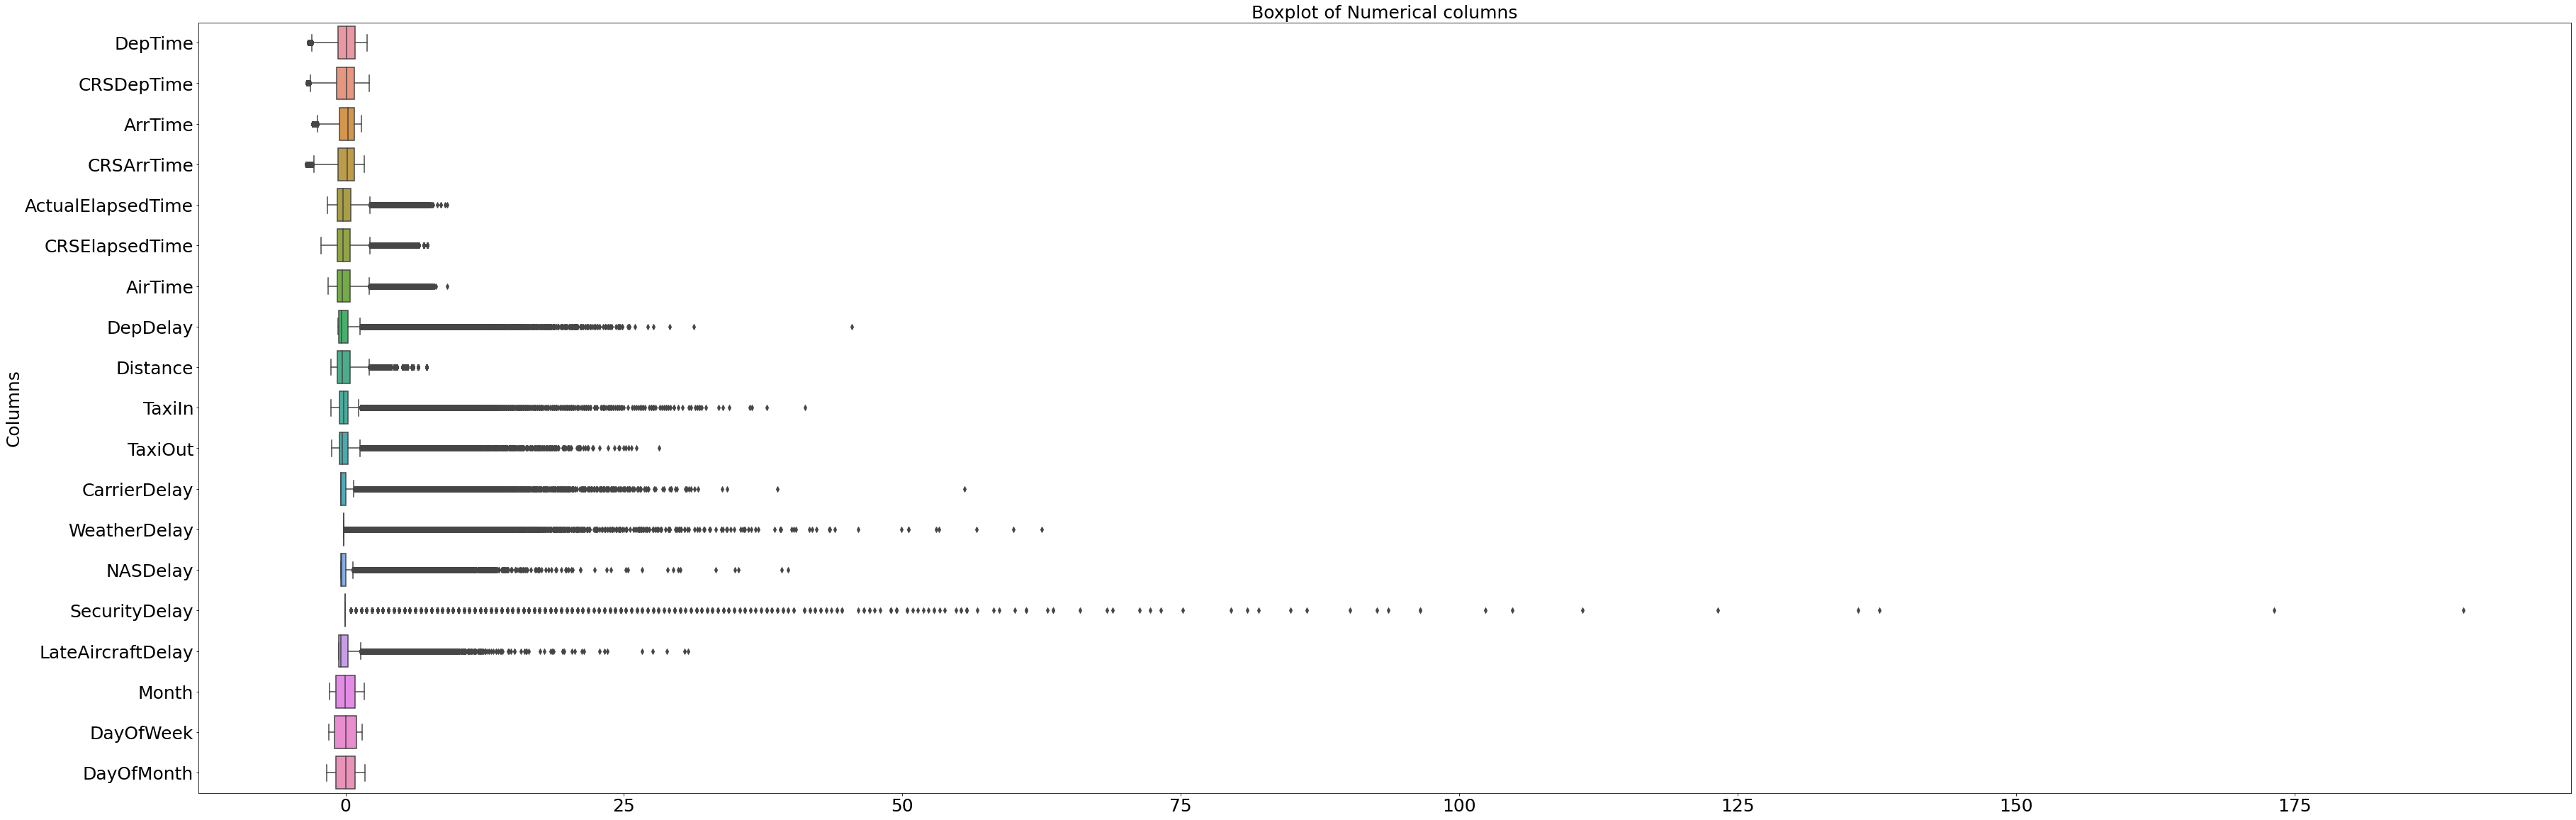


-------------------------------------------

Summary of OneHotEncoded columns:
Number of OHE columns: 5990

Number of 0's and 1's per OHE columns: 


,count,mean,std,min,25%,50%,75%,max
number_of_ones_per_column,5990.0,1.132648e+03,18549.279563,1.0,177.0,254.5,349.0,1355270.0
number_of_zeros_per_column,5990.0,1.354597e+06,18549.279563,460.0,1355381.0,1355475.5,1355553.0,1355729.0


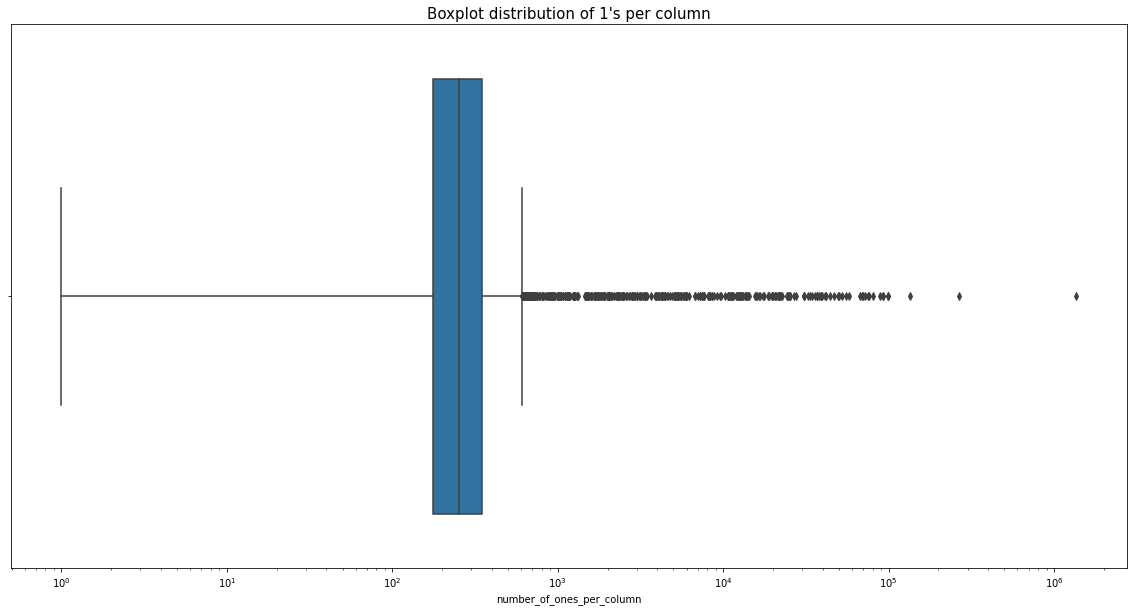

In [107]:
print(f'--------------- Summary of new columns in TRAINING SET ------------------\n')
summary_new_columns(df_new_X_train, new_num_columns, new_ohe_columns)


--------------- Summary of new columns in TEST SET ------------------

Summary of numerical columns:


,count,mean,std,min,25%,50%,75%,max,missing
DepTime,581028.0,0.000400,1.000178,-3.368726,-0.700349,0.058873,0.849174,1.956928,0
CRSDepTime,581028.0,-0.000787,1.000747,-3.453429,-0.783130,0.099906,0.818108,2.099098,0
ArrTime,578947.0,-0.000320,0.999924,-2.935463,-0.536662,0.191187,0.767629,1.440752,2081
CRSArrTime,581028.0,0.001060,0.998524,-3.515350,-0.664910,0.154726,0.819471,1.647712,0
ActualElapsedTime,578552.0,0.000077,1.001873,-1.656552,-0.740135,-0.240271,0.440100,13.617072,2476
CRSElapsedTime,580972.0,-0.000037,1.001217,-2.023456,-0.733412,-0.256656,0.430432,7.371430,56
AirTime,578552.0,0.000430,1.001529,-1.577999,-0.732655,-0.266258,0.418762,14.323213,2476
DepDelay,581028.0,0.001166,1.003794,-0.696763,-0.584281,-0.359316,0.184349,45.252281,0
Distance,581028.0,-0.000206,1.000597,-1.280904,-0.744671,-0.278078,0.404401,7.305794,0
TaxiIn,578947.0,-0.001801,0.988990,-1.288193,-0.532193,-0.154193,0.223807,44.071820,2081


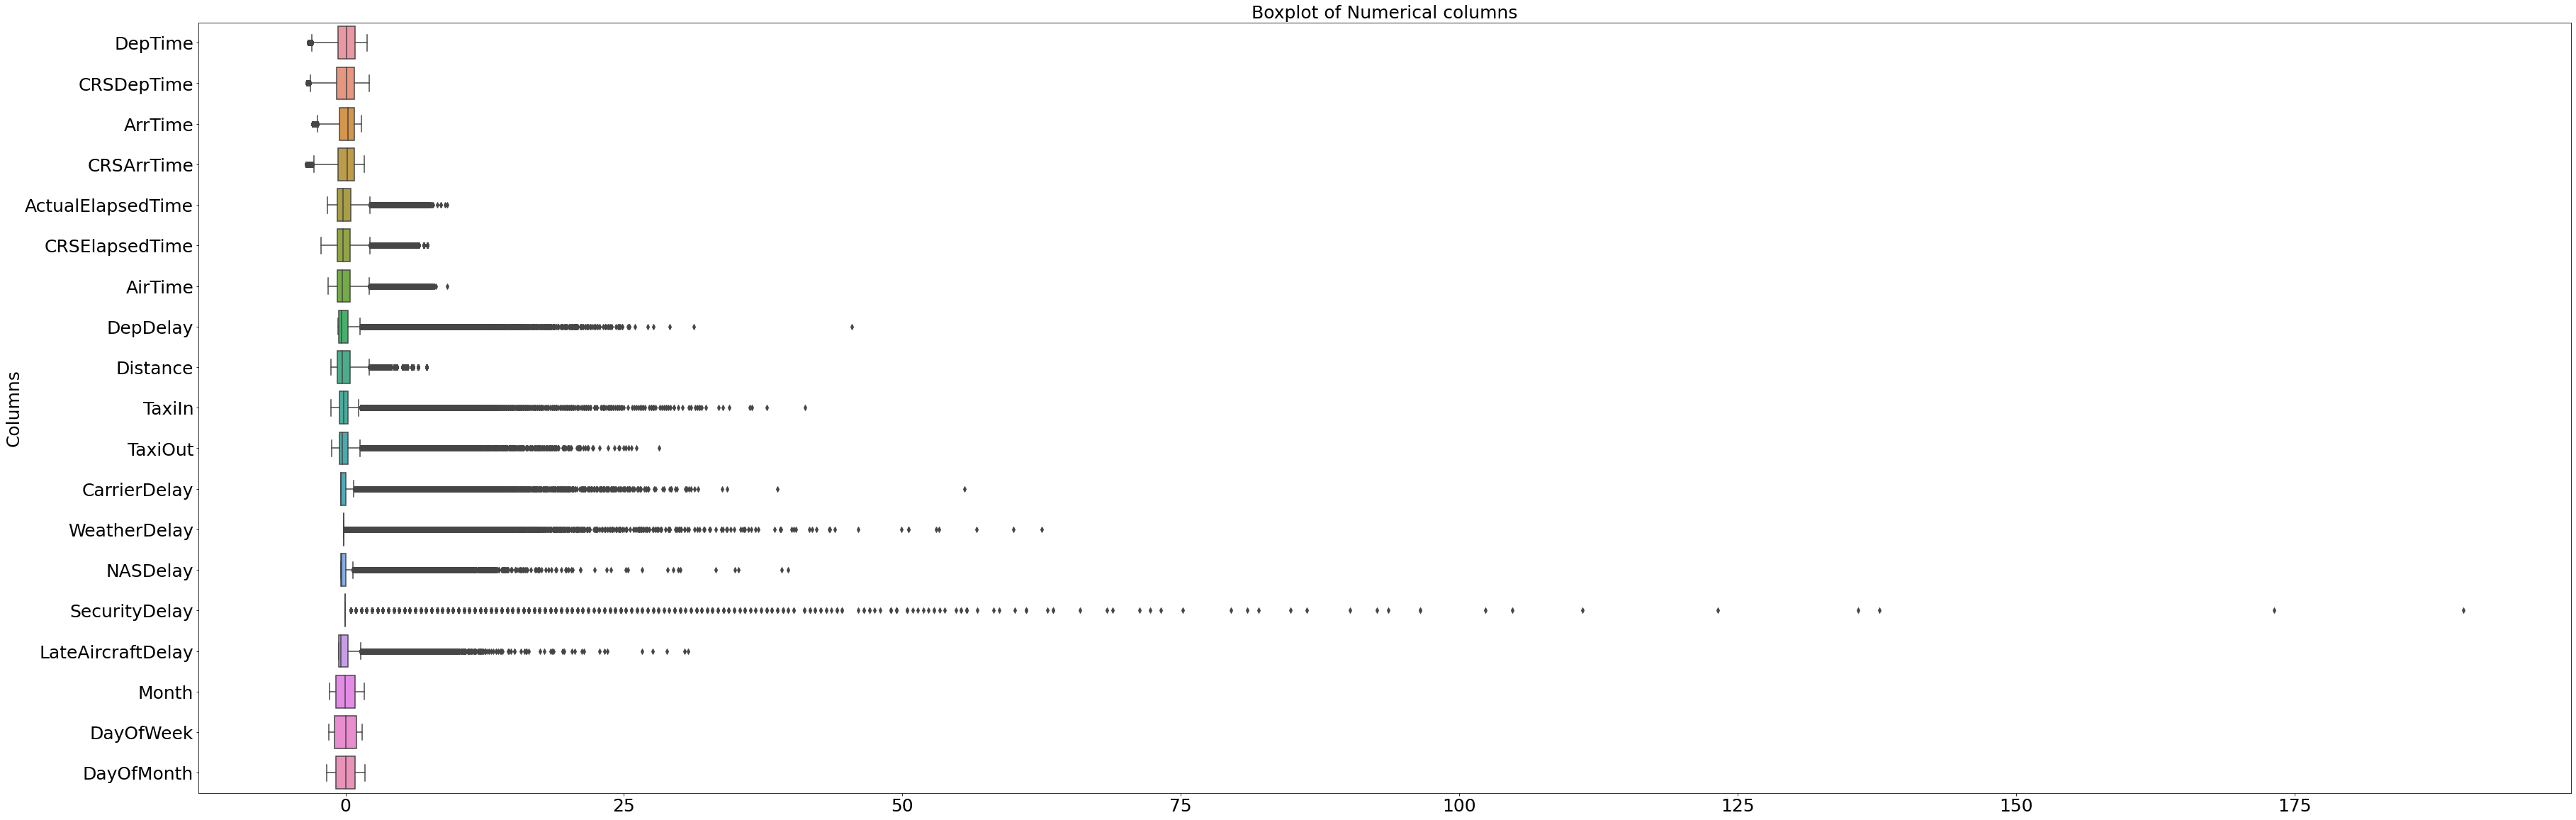


-------------------------------------------

Summary of OneHotEncoded columns:
Number of OHE columns: 5990

Number of 0's and 1's per OHE columns: 


,count,mean,std,min,25%,50%,75%,max
number_of_ones_per_column,5990.0,485.40985,7948.891419,0.0,75.0,109.0,150.0,580855.0
number_of_zeros_per_column,5990.0,580542.59015,7948.891419,173.0,580878.0,580919.0,580953.0,581028.0


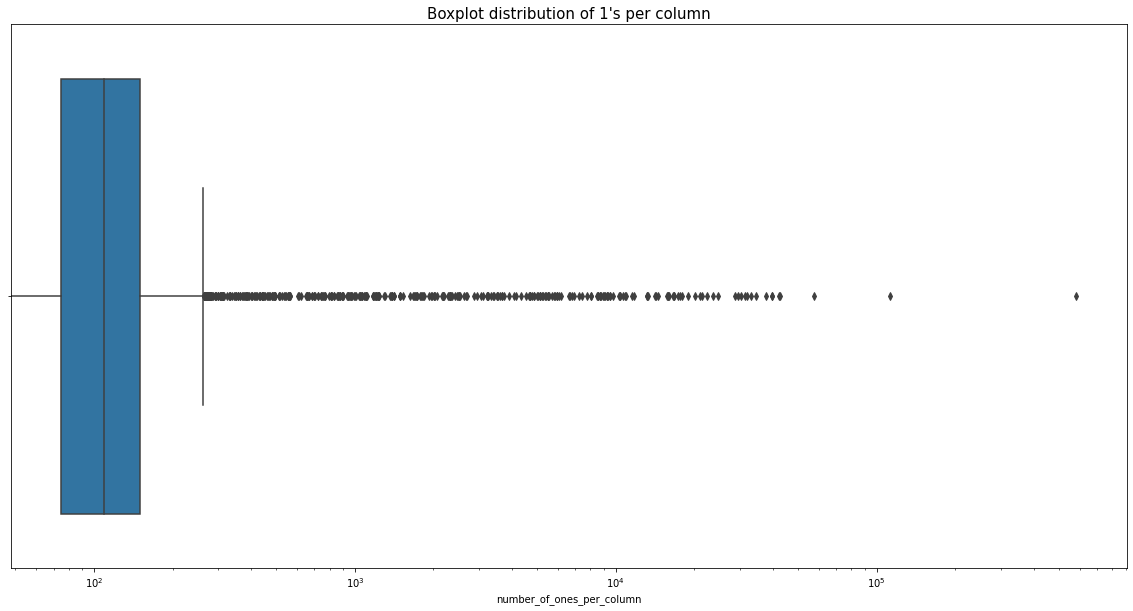

In [108]:
print(f'\n--------------- Summary of new columns in TEST SET ------------------\n')
summary_new_columns(df_new_X_test, new_num_columns, new_ohe_columns)

Podem comprovar que tant en el training set com en el test set:
- les columnes numèriques, després del preprocessament estan distribuides al voltant de mitjana 0 amb una desviació estàndar de 1
- les columnes codificades utilitzant OneHotEncoding són molt nombroses (5009 vs 19), i contenen majoritàriament valors nuls. Per això és important guardar-les en format Sparse.